In [28]:
# import aljabr
from linop import dottest, fwadjtest
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
sys.path.append('/home/plcristille/dev/utils')
import plot
from plot import load_dataset_SYNTHETIC_NOISY, NIRCam_band_mean, load_unmixed_dataset_SYNTHETIC, unmix, plot_sampled_images, plot_spec, norm_hypercube, return_mixture, noise_data_for_snr, add_poisson_noise

main_path = "/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case"
# data_path = "/home/dpineau/Bureau/data/mycube"
data_path = main_path + "/data"
output_path = main_path + "/output"

os.chdir(main_path)
from data_retrieval import inputs_for_models, abundance_maps_inputs
from criteria_definitions import QuadCriterion2, optimal_res_dicho_quad2, mu_instru, SemiQuad_Criterion_Fusion, optimal_res_dicho_semiquad2
import plot_tools
import noise_data
from reco_quality_metrics import Maps_Quality_Metrics_2
from save_and_load import Saver
from instrument_models import Spectro_Model_3, Mirim_Model_For_Fusion, Spectro_Model_Initial
from scipy.stats import entropy
import torch
from skimage import metrics
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import cv2
from pysptools.eea import NFINDR
from pysptools.abundance_maps import FCLS
import random
from importlib import reload 

sys.path.append('/home/plcristille/dev/JWST/Hubble')
from noise_functions import make_poisson_bandwise, make_image_with_snr_gaussian

In [2]:
def constrain_variate_abundance(abundances):
    abundances = norm_hypercube(abundances)
    weights = np.random.uniform(.5, 2.0, abundances.shape[0])
    logits = np.log(abundances + 1e-8) + np.log(weights[:, None, None])  # Log reweighting
    abundances_new = np.exp(logits)

    return norm_hypercube(abundances_new)

def spectral_ssim(gt: np.ndarray, pred: np.ndarray) -> float:
    """
    Compute average SSIM over all spectral bands of hyperspectral cubes.

    Parameters:
        gt (np.ndarray): Ground truth hyperspectral image, shape (bands, H, W)
        pred (np.ndarray): Predicted hyperspectral image, shape (bands, H, W)

    Returns:
        float: Mean SSIM across all spectral bands.
    """
    assert gt.shape == pred.shape, "Input shapes must match"
    bands = gt.shape[0]
    ssim_scores = []

    for i in range(bands):
        # Normalize slices to [0, 1] for fair SSIM
        gt_band = gt[i]
        pred_band = pred[i]
        
        min_val = min(gt_band.min(), pred_band.min())
        max_val = max(gt_band.max(), pred_band.max())
        if max_val - min_val > 0:
            gt_band = (gt_band - min_val) / (max_val - min_val)
            pred_band = (pred_band - min_val) / (max_val - min_val)

        score = ssim(gt_band, pred_band, data_range=1.0)
        ssim_scores.append(score)

    return np.array(ssim_scores)

def add_gaussian_noise_psnr(x, psnr_target_db):
    # Ensure input is float
    x = x.astype(np.float64)

    # Compute maximum possible value in the signal
    max_val = np.max(np.abs(x))

    # Compute required MSE from target PSNR
    mse_target = (max_val ** 2) / (10 ** (psnr_target_db / 10))

    # Standard deviation of Gaussian noise
    noise_std = np.sqrt(mse_target)

    # Generate noise and add to signal
    noise = np.random.normal(0, noise_std, size=x.shape)
    x_noisy = x + noise

    return x_noisy, noise

def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


def pan_img(img):
    img_pan = img
    weights = np.ones((img_pan.shape[0], 1, 1)) / np.float32(img_pan.shape[0])
    return np.sum(weights * img_pan, axis=0)

def calculate_ssim(img1, img2):
    img2, img1 = norm_relative_ratio(img2, img1)
    img1_pan = norm_hypercube(pan_img(img1))
    img2_pan = norm_hypercube(pan_img(img2))

    if img1_pan.shape[0]%2!=1:
        img1_pan_shape = img1_pan.shape[0]-1
    else:
        img1_pan_shape = img1_pan.shape[0]
    ssim_index, _ = metrics.structural_similarity(img1_pan, img2_pan, full=True, data_range=1.0, win_size=img1_pan_shape)

    return ssim_index

def return_RMSE(GT, mixture):
    return np.sqrt(np.mean((GT - mixture) ** 2))

def compute_sam(pred, target):
    """
    Computes the Spectral Angle Mapper (SAM) between two inputs.

    Args:
        pred (numpy.ndarray or torch.Tensor): Predicted input of shape (C, H, W) or (C,).
        target (numpy.ndarray or torch.Tensor): Ground truth input of shape (C, H, W) or (C,).
        
    Returns:
        torch.Tensor: SAM in radians. If input is 3D, returns a 2D tensor (H, W).
                      If input is 1D, returns a scalar value.
    """
    # Convert numpy arrays to torch tensors if necessary
    if isinstance(pred, np.ndarray):
        pred = torch.tensor(pred, dtype=torch.float32)
    if isinstance(target, np.ndarray):
        target = torch.tensor(target, dtype=torch.float32)
    
    # Ensure inputs have the same shape
    assert pred.shape == target.shape, "pred and target must have the same shape."
    
    # Normalize along the channel dimension
    pred_norm = pred / (torch.norm(pred, dim=0, keepdim=True) + 1e-8)
    target_norm = target / (torch.norm(target, dim=0, keepdim=True) + 1e-8)
    
    # Compute the dot product along the channel dimension
    dot_product = torch.sum(pred_norm * target_norm, dim=0)
    
    # Clamp dot_product to avoid numerical issues with arccos
    dot_product = torch.clamp(dot_product, -1.0, 1.0)
    
    # Compute the spectral angle
    sam = torch.arccos(dot_product)
    
    return sam

def norm_relative_ratio(A,B):
    # Normalize A to [0, 1]
    A_min, A_max = A.min(), A.max()
    A_norm = (A - A_min) / (A_max - A_min)

    # Normalize B keeping the original ratio with respect to A
    B_min, B_max = B.min(), B.max()
    A_range = A_max - A_min

    B_norm = (B - B_min) / A_range  # NOT divided by B_range
    return A_norm, B_norm



In [3]:
# (
#     psfs_monoch,
#     L_pce_mirim,
#     L_pce_spectro,
#     lamb_cube,
#     L_specs,
#     decim,
# ) = inputs_for_models(data_path)
# true_maps, _ = abundance_maps_inputs(data_path)

# # sous échantillonnage des cartes
# sous_ech = 2

# true_maps = true_maps[:, ::sous_ech, ::sous_ech]

# # réduction de la dimension des cartes en 40x40
# origin_area = (40, 153)
# size_i = 40
# size_j = 40

# true_maps = true_maps[:, origin_area[0] : origin_area[0] + size_i, origin_area[1] : origin_area[1] + size_j]
# shape_target = true_maps.shape[1:]

# # normalisation des cartes entre 0 et 1
# true_maps /= np.max(true_maps)
# print(true_maps.min(), true_maps.max())

# # sous échantillonnage spectral pour réduire la dimension des données

# # sous_ech_spec = 10
# # sous_ech_spec = 5 # original
# sous_ech_spec = 2
# # sous_ech_spec = 1
# L_specs = L_specs[:, ::sous_ech_spec]
# L_specs.shape

# lamb_cube = lamb_cube[::sous_ech_spec]

# psfs_monoch = psfs_monoch[::sous_ech_spec, :, :]

# L_pce_mirim = L_pce_mirim[:, ::sous_ech_spec]
# L_pce_spectro = L_pce_spectro[::sous_ech_spec]

In [4]:
margin=8
lamb_cube = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_wave.npy")
L_pce_mirim = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRCam/NIRCam_PCE.npy")
L_pce_spectro = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/PCE/NIRSpec/NIRSpec_PCE.npy")
NIRCam_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/NIRCam_PSFs.npy")
NIRSpec_PSF = np.load("/home/plcristille/dev/Webb_PSF/Saved_PSFs/NIRSpec_PSFs.npy")
NIRSpec_PSF = NIRSpec_PSF / np.sqrt((NIRSpec_PSF**2).sum(axis=(1,2), keepdims=True))

# scaler = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/scaler.npy")
lmm_specs = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/lmm_specs_SNRinf.npy")
# L_specs = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/GT_specs.npy")

# Only with absolute_true_maps
absolute_L_specs = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_L_specs.npy")

# true_maps = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/true_maps.npy")
true_maps = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/absolute_true_maps.npy")
# true_maps = np.zeros_like(true_maps)

absolute_L_specs = absolute_L_specs[[0,1,2,4]]
true_maps = true_maps[[0,1,2,4]]

spectra_broadcasted = absolute_L_specs[:, None, None, :]
abundances_expanded = true_maps[..., None]
GT = np.sum(abundances_expanded * spectra_broadcasted, axis=0).transpose(2,0,1)

# GT = np.load("/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/GT_NIR_1106_32.npy")
shape_target = true_maps.shape[1:]
decim = 2

In [5]:
# for s, spec in enumerate(absolute_L_specs):
#     absolute_L_specs[s] = add_gaussian_noise_psnr(spec, 40)[0]

# plt.plot(absolute_L_specs.T)
# plt.show()

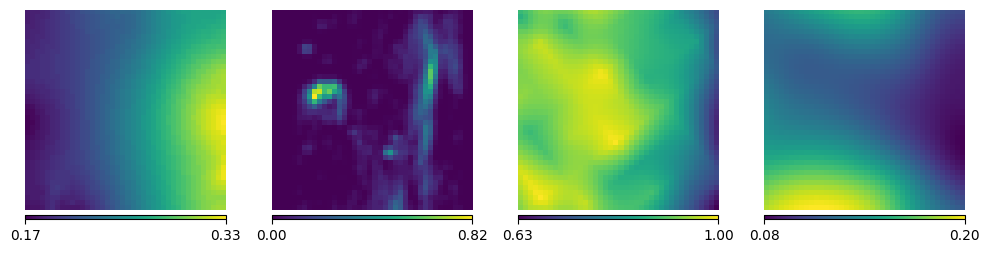

In [6]:
plot_sampled_images(true_maps, nb_columns=5, size=(10,5))

In [7]:
di = decim
dj = decim

# =============================================================================
# MIRIM MODEL
# =============================================================================

# reshape mirim model for the fusion model
mirim_model_for_fusion = Mirim_Model_For_Fusion(
    NIRCam_PSF, L_pce_mirim, lamb_cube, absolute_L_specs, shape_target, di, dj
)

# =============================================================================
# SPECTRO MODEL
# =============================================================================

# creation of spectro model from scratch
spectro_model = Spectro_Model_Initial(
    NIRSpec_PSF, L_pce_spectro, di, dj, lamb_cube, absolute_L_specs, shape_target
)

print(dottest(spectro_model))
print(fwadjtest(spectro_model))

True
True


In [8]:
L_snr = 40
snr_poisson = 150
print(f"SNR = {L_snr}")
flat = np.load("/home/plcristille/dev/JWST/NIRCam_NIRSpec/NIRSpec_spectra/FLAT_spectro_20.npy")
# y_imager, L_std_mirim = noise_data.make_obs_data_with_snr(mirim_model_for_fusion, true_maps, L_snr[0])
# y_spectro, L_std_spectro = noise_data.make_obs_data_with_snr(spectro_model, true_maps, L_snr[0])

ms_poisson, gain = make_poisson_bandwise(mirim_model_for_fusion.forward(true_maps), snr_poisson)
y_imager, L_std_mirim = make_image_with_snr_gaussian(ms_poisson, L_snr)

hs_poisson, gain = make_poisson_bandwise(spectro_model.forward(true_maps), snr_poisson)
y_spectro, L_std_spectro = make_image_with_snr_gaussian(hs_poisson, L_snr)

mu_imager = mu_instru(L_std_mirim)
mu_spectro = mu_instru(L_std_spectro)

print("y_imager.shape = {}".format(y_imager.shape))
print("y_spectro.shape = {}".format(y_spectro.shape))

SNR = 40
y_imager.shape = (28, 40, 40)
y_spectro.shape = (1106, 20, 20)


In [9]:
def extract_endmembers(hsi: np.ndarray, abundances: np.ndarray, method: str = 'max', normalize: bool = False) -> np.ndarray:
    """
    Extract endmember spectra from a hyperspectral image given abundance maps.

    Parameters
    ----------
    hsi : np.ndarray
        Hyperspectral image array of shape (bands, rows, cols).
    abundances : np.ndarray
        Abundance maps of shape (n_endmembers, rows, cols).
    method : {'max', 'average'}
        'max'     : pick pixel with highest abundance for each endmember.
        'average' : compute abundance-weighted average spectrum.
    normalize : bool
        If True and method='average', normalize by sum of abundances.

    Returns
    -------
    endmembers : np.ndarray
        Array of extracted endmember spectra of shape (n_endmembers, bands).
    """
    bands, rows, cols = hsi.shape
    n_endmembers = abundances.shape[0]
    endmembers = np.zeros((n_endmembers, bands))

    # Flatten spatial dims for easy indexing
    pixel_spectra = hsi.reshape(bands, -1)  # shape: (bands, rows*cols)
    ab_flat = abundances.reshape(n_endmembers, -1)  # shape: (n_endmembers, rows*cols)

    for i in range(n_endmembers):
        a = ab_flat[i]
        if method == 'max':
            # index of pixel with maximum abundance
            idx = np.argmax(a)
            endmembers[i] = pixel_spectra[:, idx]
        elif method == 'average':
            # weighted average of all pixels
            weights = a.astype(np.float64)
            if normalize:
                wsum = weights.sum()
                if wsum > 0:
                    weights = weights / wsum
            endmembers[i] = pixel_spectra.dot(weights)
        else:
            raise ValueError("Unknown method: choose 'max' or 'average'")

    return endmembers

from scipy.optimize import nnls
def extract_endmembers_from_abundances(hsi: np.ndarray, abundances: np.ndarray) -> np.ndarray:
    """
    Estimate endmember spectra H given user-provided abundance maps via non-negative least squares.

    Model: For each pixel j, spectrum d_j = sum_i w_{ji} * h_i,
    where w_{ji} are abundances. Solve for h_i across bands.

    Parameters
    ----------
    hsi : np.ndarray
        Hyperspectral image of shape (bands, rows, cols).
    abundances : np.ndarray
        Abundance maps of shape (n_endmembers, rows, cols).

    Returns
    -------
    H : np.ndarray
        Estimated endmember spectra of shape (n_endmembers, bands).
    """
    bands, rows, cols = hsi.shape
    n_endmembers = abundances.shape[0]

    # Flatten
    D = hsi.reshape(bands, -1).T  # shape: (pixels, bands)
    W = abundances.reshape(n_endmembers, -1).T  # shape: (pixels, n_endmembers)

    # Solve NNLS for each band
    H = np.zeros((n_endmembers, bands))
    for b in range(bands):
        # Solve W * h_band = D[:, b]
        h_band, _ = nnls(W, D[:, b])
        H[:, b] = h_band
    return H


In [13]:
np.random.seed(42)
random.seed(42)

A,E,S = unmix(y_spectro/flat, num_endmembers=4)
A = constrain_variate_abundance(A)
estimated_endmembers = extract_endmembers_from_abundances(y_spectro/flat, A)

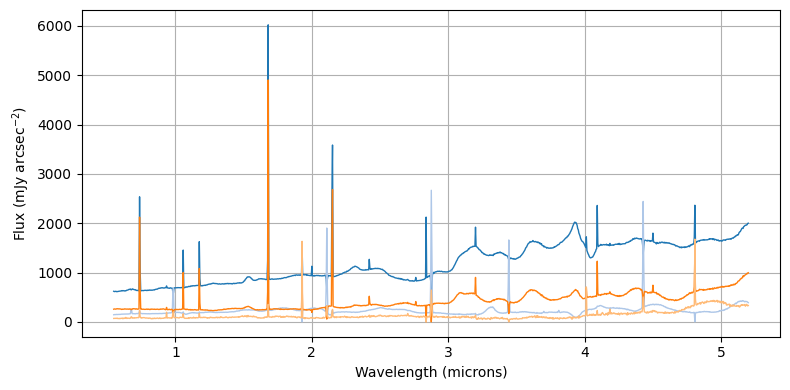

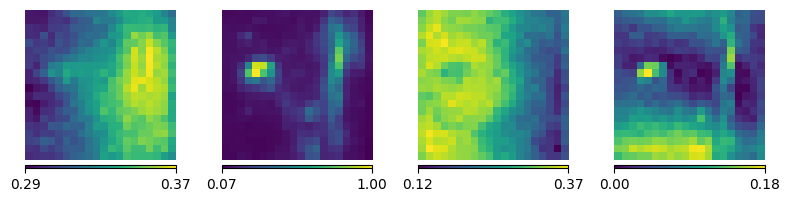

In [14]:
plot_spec(estimated_endmembers, wavelength=lamb_cube)
plot_sampled_images(A)

In [15]:
np.save("/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/RFM_GT.npy", GT[:, margin//2:-margin//2, margin//2:-margin//2])
np.save("/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/RFM_spectro.npy", (y_spectro/flat)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj])
np.save("/home/plcristille/dev/JWST/Hubble/data/Datasets/HDF5/Test/RFM_imager.npy", y_imager[:, margin//2:-margin//2, margin//2:-margin//2])

In [13]:
spectro_model = Spectro_Model_Initial(
    NIRSpec_PSF, L_pce_spectro, di, dj, lamb_cube, estimated_endmembers, shape_target
)

In [14]:
MQM = Maps_Quality_Metrics_2(true_maps, estimated_endmembers)



# mirim_model_for_fusion = Mirim_Model_For_Fusion(
#     NIRCam_PSF, L_pce_mirim, lamb_cube, lmm_specs, shape_target, di, dj
# )

# spectro_model = Spectro_Model_3(
#     NIRSpec_PSF, L_pce_spectro, di, dj, lamb_cube, lmm_specs, shape_target
# )

In [15]:
#%% search for optimal reg parameter (mu) wrt best mse

quadcriterion_test = QuadCriterion2(
    mu_imager,
    y_imager,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro,
    spectro_model,
    0,
    printing = False,
    gradient = "separated"
)

# initial range of search
list_of_mu = [100, 500]
best_mse, best_mu = optimal_res_dicho_quad2(quadcriterion_test, MQM.get_mse, list_of_mu)

# for snr 50 :
# best_mse, best_mu = 0.02156771921471, 201.5625

[100, 200.0, 300.0, 400.0, 500]
Itération n°1
L_metric [0.2230843392789456, 0.22168458466220411, 0.22118710000874517, 0.22092286733576336, 0.22075443725857946]
index_of_best_metric 4
new_list_of_mu : [400.0, 450.0, 500, 2750.0, 5000]
threshold 5.0
new_list_of_mu[0] - new_list_of_mu[-1] 4600.0


Itération n°2
L_metric [0.22092286733576336, 0.2208305376512486, 0.22075443725857946, 0.22000639852187862, 0.2198492697016811]
index_of_best_metric 4
new_list_of_mu : [2750.0, 3875.0, 5000, 27500.0, 50000]
threshold 50.0
new_list_of_mu[0] - new_list_of_mu[-1] 47250.0


Itération n°3
L_metric [0.22000639852187862, 0.21991303742943155, 0.2198492697016811, 0.21949531425303914, 0.21937957320352733]
index_of_best_metric 4
new_list_of_mu : [27500.0, 38750.0, 50000, 275000.0, 500000]
threshold 500.0
new_list_of_mu[0] - new_list_of_mu[-1] 472500.0


Itération n°4
L_metric [0.21949531425303914, 0.21943000506359625, 0.21937957320352733, 0.2189337581260258, 0.21873852336068264]
index_of_best_metric 4
new_l

In [16]:
# when with unmixed spectra
# best_mu = 0.0025405273437499997

# when with unmixed GT spectra
# best_mu = 0.4234375

# when with true GT spectra
# best_mu = 487.5

#%% run solution with the best mu

quadcriterion = QuadCriterion2(
    mu_imager,
    y_imager,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro,
    spectro_model,
    best_mu,
    printing = False,
    gradient = "separated"
)

In [17]:
minimization = "iterative" # like Guilloteau et al. (2020)
# minimization = "iterative_with_metric" # add perf_crit argument to have access to a chosen metric wrt iterations

t1 = time.time()
if minimization == "explicit" :
    quadcrit_rec_maps = quadcriterion.run_expsol()
elif minimization == "iterative" :
    res = quadcriterion.run_lcg(maximum_iterations = 1000)
    quadcrit_rec_maps = res.x
elif minimization == "iterative_with_metric" :
    res = quadcriterion.run_lcg(maximum_iterations = 1000, perf_crit = MQM.get_psnr)
    quadcrit_rec_maps = res.x
    
    plt.plot(quadcriterion.L_perf_crit)
    plt.yscale("log")
print("Time = ", time.time() - t1)

# compare map recontructions
# plot_tools.plot_maps(true_maps, quadcrit_rec_maps)
print("MSE", MQM.get_mse(quadcrit_rec_maps))
print("PSNR", MQM.get_psnr(quadcrit_rec_maps))
print("SSIM", MQM.get_ssim(quadcrit_rec_maps))
print("SAM", MQM.get_sam(quadcrit_rec_maps))

guilloteau_fused = return_mixture(absolute_L_specs, quadcrit_rec_maps.T)[:, margin//2:-margin//2, margin//2:-margin//2]

Time =  0.9525129795074463
MSE 0.21754907886355382
PSNR 31.031705537573202
SSIM 0.9704593190321306
SAM 0.08098370983922942


In [18]:
# L_snr = 25
# snr_poisson = 50
# print(f"SNR = {L_snr}")

# # y_imager, L_std_mirim = noise_data.make_obs_data_with_snr(mirim_model_for_fusion, true_maps, L_snr[0])
# # y_spectro, L_std_spectro = noise_data.make_obs_data_with_snr(spectro_model, true_maps, L_snr[0])


# ms_poisson, gain = make_poisson_bandwise(mirim_model_for_fusion.forward(true_maps), snr_poisson)
# y_imager, L_std_mirim = make_image_with_snr_gaussian(ms_poisson, L_snr)

# hs_poisson, gain = make_poisson_bandwise(spectro_model.forward(true_maps), snr_poisson)
# y_spectro, L_std_spectro = make_image_with_snr_gaussian(hs_poisson, L_snr)

# mu_imager = mu_instru(L_std_mirim)
# mu_spectro = mu_instru(L_std_spectro)

In [16]:
#  increasing values of maps so that the Huber function works as expected
mult_factor = 100
true_maps_100 = true_maps * mult_factor

# y_imager_100, L_std_mirim = noise_data.make_obs_data_with_snr(mirim_model_for_fusion, true_maps_100, L_snr[0])
# y_spectro_100, L_std_spectro = noise_data.make_obs_data_with_snr(spectro_model, true_maps_100, L_snr[0])

ms_poisson_100, gain = make_poisson_bandwise(mirim_model_for_fusion.forward(true_maps_100), snr_poisson)
y_imager_100, L_std_mirim = make_image_with_snr_gaussian(ms_poisson_100, L_snr)

hs_poisson_100, gain = make_poisson_bandwise(spectro_model.forward(true_maps_100), snr_poisson)
y_spectro_100, L_std_spectro = make_image_with_snr_gaussian(hs_poisson_100, L_snr)

# y_imager_100 = y_imager*mult_factor
# y_spectro_100 = y_spectro*mult_factor

mu_imager = mu_instru(L_std_mirim)
mu_spectro = mu_instru(L_std_spectro)

MQM_100 = Maps_Quality_Metrics_2(true_maps_100, estimated_endmembers)

In [17]:
list_of_mu = [0.02, 0.15]

scale = 0.5
n_iter_max_crit = 1000
L_thresh = [0, 1, 2, 3]
L_best_mu = []
L_best_mse = []
for t in L_thresh:
    print("t", t)
    sq_criterion_test = SemiQuad_Criterion_Fusion(
        mu_imager,
        y_imager_100,
        mirim_model_for_fusion,
        mu_spectro,
        y_spectro_100,
        spectro_model,
        mu_reg = 0,
        thresh = t,
        printing = False,
        scale = scale
    )
    
    best_mse, best_mu = optimal_res_dicho_semiquad2(sq_criterion_test,
                                                                    MQM_100.get_mse,
                                                                    list_of_mu,
                                                                    printing=True,
                                                                    max_iter=30,
                                                                    tolerance=0.01,
                                                                    n_iter_max_crit=n_iter_max_crit,
                                                                    diff_min=1e-20)
    L_best_mu.append(best_mu)
    L_best_mse.append(best_mse)

print(L_thresh)
print(L_best_mu)
print(L_best_mse)

t 0
Huber threshold = 0
Parameter scale = 0.5


[0.02, 0.0525, 0.08499999999999999, 0.1175, 0.15]
Itération n°1
L_metric [0.29510636424230036, 0.21056370641331673, 0.17641879862903148, 0.15633996200251493, 0.14256918731993248]
index_of_best_metric 4
new_list_of_mu : [0.1175, 0.13374999999999998, 0.15, 0.825, 1.5]
threshold 0.0015
new_list_of_mu[0] - new_list_of_mu[-1] 1.3825


Itération n°2
L_metric [0.15633996200251493, 0.1488971726698052, 0.14256918731993248, 0.07286828515449414, 0.0572270722898826]
index_of_best_metric 4
new_list_of_mu : [0.825, 1.1625, 1.5, 8.25, 15.0]
threshold 0.015
new_list_of_mu[0] - new_list_of_mu[-1] 14.175


Itération n°3
L_metric [0.07286828515449414, 0.06347843492553917, 0.0572270722898826, 0.029498262408981967, 0.02439254123250571]
index_of_best_metric 4
new_list_of_mu : [8.25, 11.625, 15.0, 82.5, 150.0]
threshold 0.15
new_list_of_mu[0] - new_list_of_mu[-1] 141.75


Itération n°4
L_metric [0.029498262408981967, 0.026380573267707246, 0.02439254123250571, 0

In [18]:
best_thresh = L_thresh[np.argmin(L_best_mse)]
best_mu = L_best_mu[np.argmin(L_best_mse)]

# best_thresh, best_mu = 1, 0.9568359375000001
#%%

# check courbe de MSE

sq_criterion = SemiQuad_Criterion_Fusion(
    mu_imager,
    y_imager_100,
    mirim_model_for_fusion,
    mu_spectro,
    y_spectro_100,
    spectro_model,
    mu_reg = best_mu,
    thresh = best_thresh,
    printing = True,
    scale = 0.5
)

minimization = "iterative"
# minimization = "iterative_with_metric"

t1 = time.time()
if minimization == "iterative" :
    rec_maps_sq = sq_criterion.run_expsol(n_iter_max = 20000, diff_min = 1e-25, calc_crit = False)
elif minimization == "iterative_with_metric" :
    rec_maps_sq = sq_criterion.run_expsol(n_iter_max = 2000, diff_min = 1e-25, calc_crit = False, perf_crit = MQM_100.get_psnr)
    
    L_mse_sq = sq_criterion.L_perf_crit
    plt.plot(L_mse_sq)
    
print(time.time() - t1)


# compare map recontructions
# plot_tools.plot_maps(true_maps, rec_maps_sq)
print("MSE", MQM_100.get_mse(rec_maps_sq))
print("PSNR", MQM_100.get_psnr(rec_maps_sq))
print("SSIM", MQM_100.get_ssim(rec_maps_sq))
print("SAM", MQM_100.get_sam(rec_maps_sq))

pineau_l2 = ((return_mixture(estimated_endmembers, rec_maps_sq.T) / mult_factor)[:, margin//2:-margin//2, margin//2:-margin//2])

Huber threshold = 1
Parameter scale = 0.5


iteration 2000, diff = 1.310495339504e-19
Reconstruction ended
Number of executed iterations : 3315 (2.225 sec)
Total time needed = 0.057 + 2.225 = 2.282 sec.
Iterations ended due to :
Difference between iterated solutions < threshold (1e-25).


2.2822937965393066
MSE 0.007114501270410133
PSNR 61.18270027297109
SSIM 0.999427682790604
SAM 0.002380830626554337


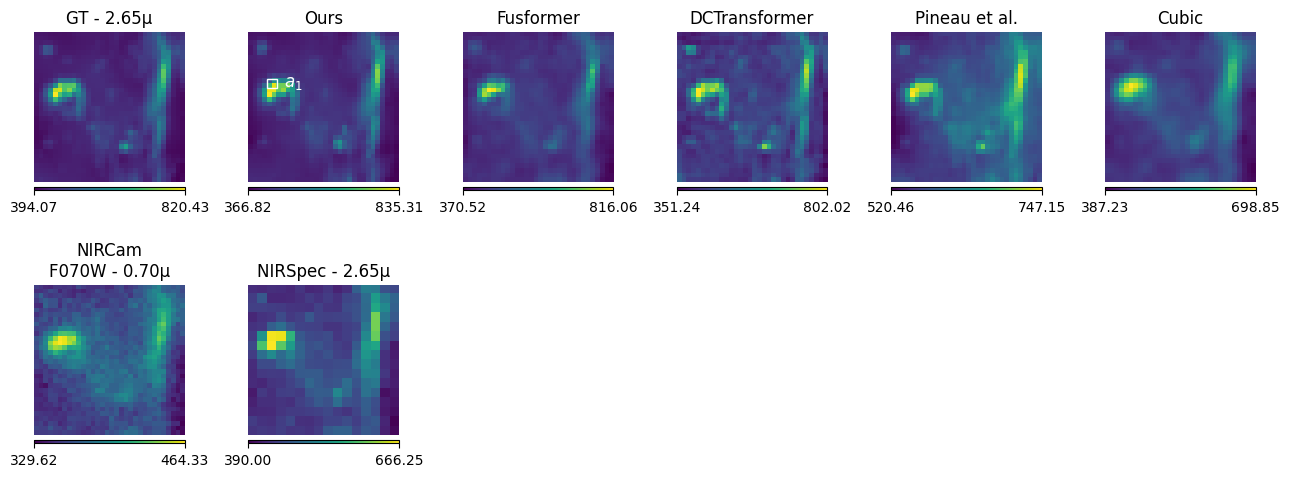

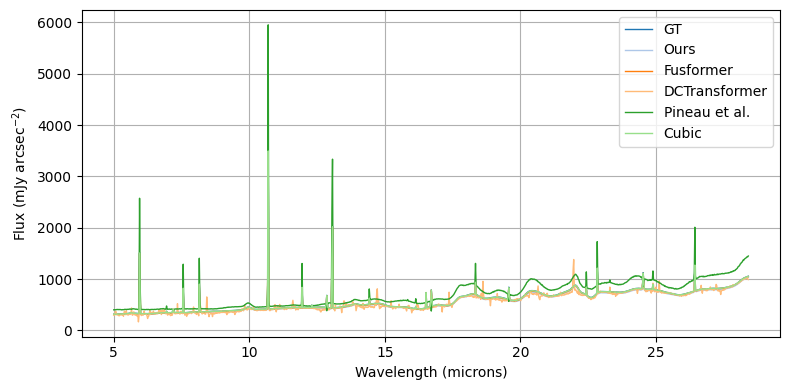

,Ours,Fusformer,DCTransformer,Pineau et al.,Cubic
Metric,,,,,
RMSE,0.006,0.007,0.094,0.044,0.009
PSNR,44.482,43.593,30.536,30.987,41.529
SAM,0.024,0.021,0.124,0.109,0.019
SSI,0.915,0.860,0.797,0.542,0.759


In [42]:
%matplotlib inline

AI_fused = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/AI-fused.npy")
AI_fused_Fusformer = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/AI-fused_FUSFORMER.npy")
AI_fused_DCTransformer = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/AI-fused_DCTransformer.npy")

y_imager_final = y_imager[:, margin//2:-margin//2, margin//2:-margin//2]
y_spectro_final = (y_spectro/flat)[:, (margin//2)//di:-(margin//2)//di, (margin//2)//dj:-(margin//2)//dj]

GT_final = GT[:, margin//2:-margin//2, margin//2:-margin//2]
# GT_final = np.load("/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/data_new/infer_GT.npy")

interp_fused = np.empty_like(GT_final)
for i, band in enumerate(y_spectro_final):
    interp_fused[i] = cv2.resize(band, dsize=(GT_final.shape[1], GT_final.shape[2]), interpolation=cv2.INTER_CUBIC)

rect_d = (4,10,2,2)
b_HS, b_MS = 500, 0
reload(plot)
plot.plot_sampled_images([GT_final[b_HS], AI_fused[b_HS], AI_fused_Fusformer[b_HS], AI_fused_DCTransformer[b_HS], pineau_l2[b_HS], interp_fused[b_HS], y_imager_final[b_MS], y_spectro_final[b_HS]], 
                    filters=[f"GT - {lamb_cube[b_HS]:.2f}μ", "Ours", "Fusformer", "DCTransformer", "Pineau et al.", "Cubic", f"NIRCam\n{list(NIRCam_band_mean.keys())[b_MS]} - {list(NIRCam_band_mean.values())[b_MS]:.2f}μ", f"NIRSpec - {lamb_cube[b_HS]:.2f}μ"], 
                    nb_columns=6, size=(13,15), rect_locDim=((rect_d[0]-.5,rect_d[1]-.5,rect_d[2],rect_d[3]),),
                    ax_rect={2:[1]}, rect_name=[r"$a_1$"],
                    savepath="/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/media/compared_results.pdf")

plot_spec([GT_final.mean(axis=(1,2)), 
           AI_fused.mean(axis=(1,2)), 
           AI_fused_Fusformer.mean(axis=(1,2)), 
           AI_fused_DCTransformer.mean(axis=(1,2)), 
           pineau_l2.mean(axis=(1,2)), 
           interp_fused.mean(axis=(1,2))], 
           filters=["GT", 
                   "Ours", 
                   "Fusformer", 
                   "DCTransformer", 
                   "Pineau et al.", 
                   "Cubic"],
            savepath="/home/plcristille/dev/JWST/fusion_inverse/MS-HS-Fusion-Study-Case/media/compared_results_specs.pdf")


pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(AI_fused,GT_final)
RMSE = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR = calculate_psnr(AI_fused, GT_final, max_value=AI_fused.max())
SAM = compute_sam(GT_final, AI_fused).mean()
SSI = spectral_ssim(GT_final, AI_fused).mean()

pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(AI_fused_Fusformer,GT_final)
RMSE_FUS = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR_FUS = calculate_psnr(AI_fused_Fusformer, GT_final, max_value=AI_fused_Fusformer.max())
SAM_FUS = compute_sam(GT_final, AI_fused_Fusformer).mean()
SSI_FUS = spectral_ssim(GT_final, AI_fused_Fusformer).mean()

pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(AI_fused_DCTransformer,GT_final)
RMSE_DCT = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR_DCT = calculate_psnr(AI_fused_DCTransformer, GT_final, max_value=AI_fused_DCTransformer.max())
SAM_DCT = compute_sam(GT_final, AI_fused_DCTransformer).mean()
SSI_DCT = spectral_ssim(GT_final, AI_fused_DCTransformer).mean()

# pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(guilloteau_fused,GT_final)
# RMSE_G = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
# PSNR_G = calculate_psnr(guilloteau_fused, GT_final, max_value=guilloteau_fused.max())
# SAM_G = compute_sam(GT_final, guilloteau_fused).mean()
# SSI_G = spectral_ssim(GT_final, guilloteau_fused).mean()

pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(pineau_l2,GT_final)
RMSE_P = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR_P = calculate_psnr(pineau_l2, GT_final, max_value=pineau_l2.max())
SAM_P = compute_sam(GT_final, pineau_l2).mean()
SSI_P = spectral_ssim(GT_final, pineau_l2).mean()

pred_normed_RMSE, GT_normed_RMSE = norm_relative_ratio(interp_fused,GT_final)
RMSE_I = return_RMSE(GT_normed_RMSE, pred_normed_RMSE)
PSNR_I = calculate_psnr(interp_fused, GT_final, max_value=interp_fused.max())
SAM_I = compute_sam(GT_final, interp_fused).mean()
SSI_I = spectral_ssim(GT_final, interp_fused).mean()

data = {
    'Metric': ['RMSE', 'PSNR', 'SAM', 'SSI'],
    'Ours': [f"{RMSE:.3f}", f"{PSNR:.3f}", f"{SAM:.3f}", f"{SSI:.3f}"],
    'Fusformer': [f"{RMSE_FUS:.3f}", f"{PSNR_FUS:.3f}", f"{SAM_FUS:.3f}", f"{SSI_FUS:.3f}"],
    'DCTransformer': [f"{RMSE_DCT:.3f}", f"{PSNR_DCT:.3f}", f"{SAM_DCT:.3f}", f"{SSI_DCT:.3f}"],
    # 'Guilloteau et al.': [f"{RMSE_G:.3f}", f"{PSNR_G:.3f}", f"{SAM_G:.3f}", f"{SSI_G:.3f}"],
    'Pineau et al.': [f"{RMSE_P:.3f}", f"{PSNR_P:.3f}", f"{SAM_P:.3f}", f"{SSI_P:.3f}"],
    'Cubic': [f"{RMSE_I:.3f}", f"{PSNR_I:.3f}", f"{SAM_I:.3f}", f"{SSI_I:.3f}"]
}

# Create and display the DataFrame
df = pd.DataFrame(data)
df.set_index('Metric', inplace=True)
df

In [43]:
def make_latex_table(df, caption="Metrics Table", label="tab:label", figure_ref="fig:figure"):
    lower_better = {"RMSE", "SAM"}
    higher_better = {"PSNR", "SSI"}

    metrics = df.index.tolist()
    methods = df.columns.tolist()

    latex = fr"""\begin{{table}}
  \begin{{center}}
  \caption{{{caption}}}
  \label{{{label}}}
  \begin{{tabular}}{{| c {"| c" * len(metrics)} |}}
  \hline
  Method & {' & '.join(metrics)}\\
  \hline
"""

    # Precompute best and second-best indices per metric
    best_indices = {}
    second_best_indices = {}

    for metric in metrics:
        values = np.array([float(df[method][metric]) for method in methods])
        if metric in lower_better:
            sorted_indices = np.argsort(values)
        elif metric in higher_better:
            sorted_indices = np.argsort(-values)
        else:
            sorted_indices = np.arange(len(values))

        best_indices[metric] = sorted_indices[0]
        second_best_indices[metric] = sorted_indices[1]

    # Build LaTeX table rows
    for i, method in enumerate(methods):
        row_values = []
        for metric in metrics:
            value = float(df[method][metric])
            val_str = f"{value:.3f}"
            if i == best_indices[metric]:
                val_str = r"\textbf{" + val_str + "}"
            elif i == second_best_indices[metric]:
                val_str = r"\underline{" + val_str + "}"
            row_values.append(val_str)

        latex += f"  {method} & {' & '.join(row_values)}\\\\\n  \\hline\n"

    latex += r"""  \end{tabular}
  \end{center}
\end{table}"""

    return latex


latex_code = make_latex_table(df, caption="Metrics for the fusion showcased in Figure \\ref{fig:fusion_result}.", 
                              label="tab:fusion_result", 
                              figure_ref="fig:fusion_result")
print(latex_code)

\begin{table}
  \begin{center}
  \caption{Metrics for the fusion showcased in Figure \ref{fig:fusion_result}.}
  \label{tab:fusion_result}
  \begin{tabular}{| c | c| c| c| c |}
  \hline
  Method & RMSE & PSNR & SAM & SSI\\
  \hline
  Ours & \textbf{0.006} & \textbf{44.482} & 0.024 & \textbf{0.915}\\
  \hline
  Fusformer & \underline{0.007} & \underline{43.593} & \underline{0.021} & \underline{0.860}\\
  \hline
  DCTransformer & 0.094 & 30.536 & 0.124 & 0.797\\
  \hline
  Pineau et al. & 0.044 & 30.987 & 0.109 & 0.542\\
  \hline
  Cubic & 0.009 & 41.529 & \textbf{0.019} & 0.759\\
  \hline
  \end{tabular}
  \end{center}
\end{table}


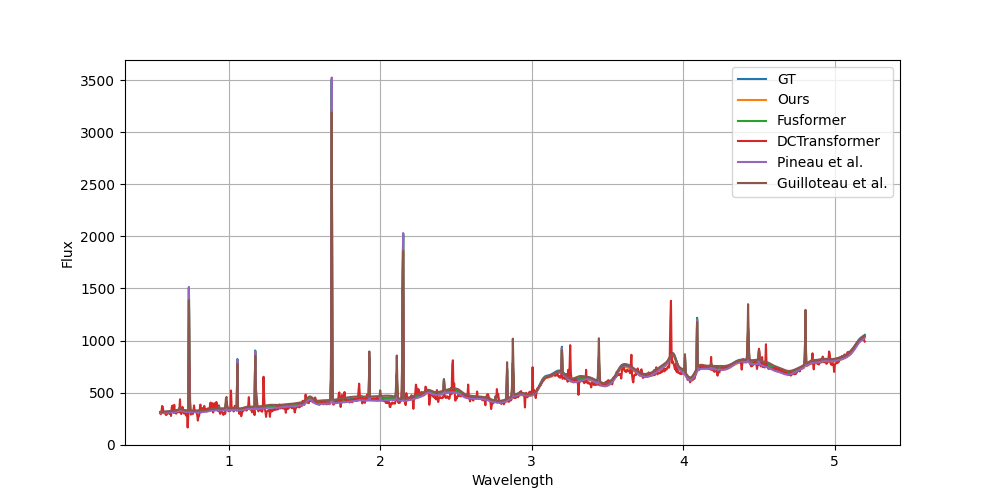

In [89]:
%matplotlib widget
import mplcursors

plt.figure(figsize=(10,5))

line1, = plt.plot(lamb_cube, GT_final.mean(axis=(1,2)), label = "GT")
line2, = plt.plot(lamb_cube, AI_fused.mean(axis=(1,2)), label = "Ours")
line3, = plt.plot(lamb_cube, AI_fused_Fusformer.mean(axis=(1,2)), label = "Fusformer")
line4, = plt.plot(lamb_cube, AI_fused_DCTransformer.mean(axis=(1,2)), label = "DCTransformer")
line5, = plt.plot(lamb_cube, pineau_l2.mean(axis=(1,2)), label = "Pineau et al.")
line6, = plt.plot(lamb_cube, guilloteau_fused.mean(axis=(1,2)), label = "Guilloteau et al.")


plt.grid()
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend()

cursor = mplcursors.cursor([line1, line2, line3, line4, line5, line6], hover=True)

@cursor.connect("add")
def on_add(sel):
    sel.annotation.set_text(sel.artist.get_label())

plt.show()

In [90]:
plt.close()
%matplotlib inline